# Random Walk Generation

Recall that the stochastic model for asset returns is given by the Geometric Brownian Motion process:

$$ \frac{S_{t+dt}-S_t}{S_t} = \mu dt + \sigma\sqrt{dt}\xi_t $$

When we generate simulated returns, we can usually ignore the decomposition of $\mu$ since we only care about the net effective drift term without worrying about what the components of it are.

The implementation is really very close to the equation above, although it can be optimized in many ways, this is the most direct translation of the equation:

```python
import numpy as np

def gbm(n_years = 10, n_scenarios=1000, mu=0.07, sigma=0.15, steps_per_year=12, s_0=100.0):
    """
    Evolution of Geometric Brownian Motion trajectories, such as for Stock Prices
    :param n_years:  The number of years to generate data for
    :param n_paths: The number of scenarios/trajectories
    :param mu: Annualized Drift, e.g. Market Return
    :param sigma: Annualized Volatility
    :param steps_per_year: granularity of the simulation
    :param s_0: initial value
    :return: a numpy array of n_paths columns and n_years*steps_per_year rows
    """
    # Derive per-step Model Parameters from User Specifications
    dt = 1/steps_per_year
    n_steps = int(n_years*steps_per_year)
    # Generate psi of t (Brownian motion component, random walk)
    xi = np.random.normal(size=(n_steps, n_scenarios))
    # start with just the returns, biased by mu_dt plus 1 since we'll need that later
    rets = mu*dt + sigma*np.sqrt(dt)*xi
    # convert the returns to prices
    prices = s_0*(1+rets).cumprod()
    return prices
```    

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

def gbm0(n_years = 10, n_scenarios=1000, mu=0.07, sigma=0.15, steps_per_year=12, s_0=100.0):
    """
    Evolution of Geometric Brownian Motion trajectories, such as for Stock Prices
    :param n_years:  The number of years to generate data for
    :param n_paths: The number of scenarios/trajectories
    :param mu: Annualized Drift, e.g. Market Return
    :param sigma: Annualized Volatility
    :param steps_per_year: granularity of the simulation
    :param s_0: initial value
    :return: a numpy array of n_paths columns and n_years*steps_per_year rows
    """
    # Derive per-step Model Parameters from User Specifications
    dt = 1/steps_per_year
    n_steps = int(n_years*steps_per_year)
    xi = np.random.normal(size=(n_steps, n_scenarios))
    rets = mu*dt + sigma*np.sqrt(dt)*xi
    # convert to a DataFrame
    rets = pd.DataFrame(rets)
    # convert to prices
    prices = s_0*(rets+1).cumprod()
    return prices


In [2]:
p = gbm0(n_years=10, n_scenarios=10000, mu=0.07)

In [3]:
p.shape

(120, 10000)

In [4]:
p.iloc[-1].shape

(10000,)

In [5]:
p.iloc[-1].mean(), 100*1.07**10

(201.8332160061751, 196.71513572895665)

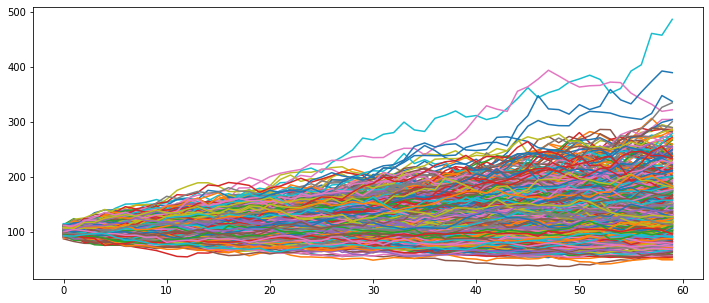

In [6]:
gbm0(n_years=5, n_scenarios=1000, mu=0.07).plot(figsize=(12,5), legend=False)

In [7]:
%timeit gbm0(n_years=5, n_scenarios=1000, mu=0.07)

6.11 ms ± 285 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
# Optimization of the performance of the gbm function
def gbm1(n_years = 10, n_scenarios=1000, mu=0.07, sigma=0.15, steps_per_year=12, s_0=100.0):
    """
    Evolution of Geometric Brownian Motion trajectories, such as for Stock Prices
    :param n_years:  The number of years to generate data for
    :param n_paths: The number of scenarios/trajectories
    :param mu: Annualized Drift, e.g. Market Return
    :param sigma: Annualized Volatility
    :param steps_per_year: granularity of the simulation
    :param s_0: initial value
    :return: a numpy array of n_paths columns and n_years*steps_per_year rows
    """
    # Derive per-step Model Parameters from User Specifications
    dt = 1/steps_per_year
    n_steps = int(n_years*steps_per_year)
    # loc is the mean and scale is the standard deviation
    rets_plus_1 = np.random.normal(loc=(mu*dt+1), scale=(sigma*np.sqrt(dt)), size=(n_steps, n_scenarios))
    prices = s_0*pd.DataFrame(rets_plus_1).cumprod()
    return prices


In [9]:
gbm1(n_years=10, n_scenarios=10000, mu=0.07).iloc[-1].mean(), 100*1.07**10

(201.2781763113608, 196.71513572895665)

In [10]:
%timeit gbm1(n_years=5, n_scenarios=1000, mu=0.07)

5.81 ms ± 321 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


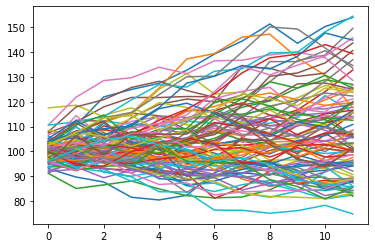

In [11]:
gbm1(n_years=1, n_scenarios=100, mu=0.07).plot(legend=False)

Note how the stock prices already reflect the first return. We'd like the prices to start out at `s_0` and then evolve. Let's fix that and add it to our toolkit and call this done!

In [12]:
def gbm(n_years = 10, n_scenarios=1000, mu=0.07, sigma=0.15, steps_per_year=12, s_0=100.0):
    """
    Evolution of Geometric Brownian Motion trajectories, such as for Stock Prices
    :param n_years:  The number of years to generate data for
    :param n_paths: The number of scenarios/trajectories
    :param mu: Annualized Drift, e.g. Market Return
    :param sigma: Annualized Volatility
    :param steps_per_year: granularity of the simulation
    :param s_0: initial value
    :return: a numpy array of n_paths columns and n_years*steps_per_year rows
    """
    # Derive per-step Model Parameters from User Specifications
    dt = 1/steps_per_year
    n_steps = int(n_years*steps_per_year) + 1
    rets_plus_1 = np.random.normal(loc=(mu*dt+1), scale=(sigma*np.sqrt(dt)), size=(n_steps, n_scenarios))
    # fix to make the prices to start at s_0
    rets_plus_1[0] = 1
    prices = s_0*pd.DataFrame(rets_plus_1).cumprod()
    return prices

In [13]:
import edhec_risk_kit_121 as erk

%timeit erk.gbm(n_years=5, n_scenarios=1000, mu=0.07)

4.84 ms ± 322 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


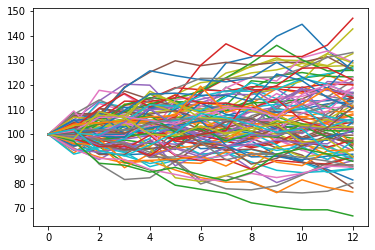

In [14]:
erk.gbm(n_years=1, n_scenarios=100, mu=0.07).plot(legend=False)

In [15]:
erk.gbm(n_years=10, n_scenarios=10000, mu=0.07, steps_per_year=12).iloc[-1].mean(), 100*1.07**10

(201.27262985305126, 196.71513572895665)

## Exercise to the student: _Why are the terminal prices slightly, but consistently biased upwards?_

To fix the bias, replace:
```python
loc=mu*dt+1
```
in the call to `np.random.normal` by
```python
loc=(1+mu)**dt
```

and rerun it, and you will see that the bias is eliminated.

_Hint: To understand why this works, you will need to think about how the per-step drift is computed._


In [16]:
def gbm2(n_years = 10, n_scenarios=1000, mu=0.07, sigma=0.15, steps_per_year=12, s_0=100.0):
    """
    Evolution of Geometric Brownian Motion trajectories, such as for Stock Prices
    :param n_years:  The number of years to generate data for
    :param n_paths: The number of scenarios/trajectories
    :param mu: Annualized Drift, e.g. Market Return
    :param sigma: Annualized Volatility
    :param steps_per_year: granularity of the simulation
    :param s_0: initial value
    :return: a numpy array of n_paths columns and n_years*steps_per_year rows
    """
    # Derive per-step Model Parameters from User Specifications
    dt = 1/steps_per_year
    n_steps = int(n_years*steps_per_year) + 1
    rets_plus_1 = np.random.normal(loc=(1+mu)**dt, scale=(sigma*np.sqrt(dt)), size=(n_steps, n_scenarios))
    rets_plus_1[0] = 1
    prices = s_0*pd.DataFrame(rets_plus_1).cumprod()
    return prices

In [17]:
gbm2(n_years=10, n_scenarios=10000, mu=0.07, steps_per_year=12).iloc[-1].mean(), 100*1.07**10

(197.12441630191438, 196.71513572895665)